(content:references:tabular_part5)=
# *The Physics Informed Neural Network*

***Author: Marc Hon (mtyhon@nus.edu.sg), Earl Patrick Bellinger (earl.bellinger@yale.edu)***

Physics-Informed Neural Networks (PINNs) are neural networks that solves or approximates solutions to physical systems governed by differential equations, using prior physical knowledge (e.g., conservation laws, PDEs, ODEs) encoded **directly** into the loss function during training.

Rather than being purely data-driven like classical machine learning, PINNs are directly constrained to produce outputs consistent with physics.

## Formulation

A Physics-Informed Neural Network solves problems where the solution $ u $ must satisfy a differential equation of the form:

$$
\mathcal{F}\!\left(u(\boldsymbol{\xi}); \boldsymbol{\xi} \right) = 0,
$$

where:
- $ \boldsymbol{\xi} \in \mathbb{R}^d $ denotes the independent variables (e.g., radius $r$, time $t$, orbital phase $\phi$, or frequency $\nu$),
- $ u(\boldsymbol{\xi}) $ is the unknown function to approximate,
- $ \mathcal{F} $ is a differential operator encoding the governing physical laws.

A neural network $ u_\theta(\boldsymbol{\xi}) $ with parameters $\theta$ is trained to minimize a composite loss involving the following:


**Data Loss** (fitting observations):


>$$
\mathcal{L}_{\text{data}} = \frac{1}{N} \sum_{i=1}^{N} 
\big( u_\theta(\boldsymbol{\xi}_i) - u_i^{\text{obs}} \big)^2
$$

**Physics Loss** (enforcing the governing equations):


>$$
\mathcal{L}_{\text{physics}} = \frac{1}{M} \sum_{j=1}^{M}
\left( \mathcal{F}\!\left(u_\theta; \boldsymbol{\xi}_j\right) \right)^2
$$

Many physical systems also require **Boundary or Initial Conditions** at a boundary  $ \partial \Omega $ in addition to the governing equations:

$$
\mathcal{B}\!\left(u(\boldsymbol{\xi})\right) = 0,
\qquad \boldsymbol{\xi} \in \partial \Omega, 
$$

such that

>$$
\mathcal{L}_{\text{bc}} =
\frac{1}{K} \sum_{k=1}^{K}
\left( \mathcal{B}(u_\theta; \boldsymbol{\xi}_k) \right)^2
$$


Putting it altogether, we have


>$$
\mathcal{L}(\theta) = 
\mathcal{L}_{\text{data}} + \lambda_{\text{phys}} \,\mathcal{L}_{\text{physics}} + \lambda_{\text{bc}} \,\mathcal{L}_{\text{bc}},
$$


Here:
- $ \{ (\boldsymbol{\xi}_i, u_i^{\text{obs}}) \} $ are observation points,
- $ \{ \boldsymbol{\xi}_j \} $ are collocation points (chosen freely within the domain),
- $ \lambda_{\text{phys}} $ and $\lambda_{\text{bc}}$ are weighting parameters balancing data fidelity and physical consistency for the physics and boundary loss, respectively.

Here, **automatic differentiation** will be used to obtain the derivatives required in $\mathcal{F}$.


## Example: The Lane-Emden Equation

The Lane-Emden equation is a simplified model for the internal structure of the star, taking the form of

```{math}
:label: eq-lane-emden
\frac{1}{\xi^2} \frac{d}{d\xi} \left( \xi^2 \frac{d\theta}{d\xi} \right) + \theta^n = 0
```

with the following **boundary conditions**:

```{math}
:label: boundary-lane-emden
\begin{align}
\theta &= 1 \quad \text{for} \quad \xi = 0 \\
d\theta/d\xi &= 0 \quad \text{for} \quad \xi = 0,
\end{align}
```

where the surface of the star is defined as $\xi_1$, where

$$
\begin{align}
\theta &= 0 \quad \text{for} \quad \xi = \xi_1.
\end{align}
$$

```{admonition} Physical Interpretation
:class: tip
The structures of stars are governed by the equations of stellar structure, The pressure $P$ and density $\rho$ in the interiors of stars are governed by the following ODEs in particular:

$$
\begin{align}
\frac{dP}{dm} &= -\frac{Gm}{4\pi r^4} \quad \text{(hydrostatic equilibrium)}\\
\frac{dr}{dm} &= -\frac{1}{4\pi r^2 \rho} \quad \text{(mass continuity)},
\end{align}
$$

where $m$ is the mass enclosed inside a shell of radius $r$ within the star, and $G$ is the gravitational constant.

The above equations can be solved in the case where $\rho$ can be expressed as a function of $P$ in the following form:

$$
P = K\rho^{(1 + \frac{1}{n})},
$$

which are known as **polytropic models**, with $n$ known as the *polytropic index*. Here, we introduce the dimensionless values

$$
\begin{align}
\rho(r) &= \rho_c \theta^n (r) \\
r &= \alpha\xi, \quad \text{where} \quad \alpha^2 = \frac{(n+1)K\rho_c^{1/n - 1}}{4\pi G},
\end{align}
$$

with $\rho_c$ being the central density of the star. The boundary conditions naturally arise from these parameterizations of $\rho$ and $r$ into $\theta$ and $\xi$, respectively.

Polytropes are widely used as simplified models of stellar and planetary interiors:

- **$n = 0$**: Constant density (incompressible), first-order model for rocky planets.

- **$n \approx 0.5 – 1$**:  Models for neutron stars.

- **$n = 1.5$**:  Fully convective stars like brown dwarfs and gas giant planets, low-mass white dwarfs.

- **$n = 3$**: Massive white dwarfs, main-sequence stars in their radiation zone.

- **$n = 5$**: Infinite radius.

```

### Generating Lane-Emden Equations

We want to solve the Lane-Emden Equation for a given polytropic index $n$. Analytical solutions exists for $n=1,3,5$, but for the other cases numerical integration is required. In the following, we will create a function that uses the **predictor–corrector method** for numerically solving the Lane–Emden equations at logarithmically-spaced co-location points $\xi$.

In [125]:
import os, re
import scienceplots
import numpy as np
import pandas as pd
import seaborn as sns
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils as nn_utils
import torch.nn.init as init

from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from torch.utils import data
from torch.func import functional_call, vmap, grad
from tqdm.notebook import trange, tqdm

plt.style.use('science'); fs=15
plt.rcParams['text.usetex'] = False

DTYPE = torch.float64

torch.set_default_dtype(torch.float64)

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter3' / 'data'

In [113]:
def solveLaneEmden(log_delta_xi, n, terminate = 'firstzero'):

    delta_xi = 10**log_delta_xi

    # Inner boundary condition
    y0 = 1 - delta_xi**2/6
    z0 = -delta_xi**3/3

    ys  = [y0]
    zs  = [z0]
    xis = [delta_xi]
    ycs = [y0]
    zcs = [z0]
    
    while True:
        y  =  ys[len(ys)  - 1]
        z  =  zs[len(zs)  - 1]
        xi = xis[len(xis) - 1]
        yc = ycs[len(ycs) - 1]
        zc = zcs[len(zcs) - 1]

        ## Primitive method
        yi = y + delta_xi * z/xi**2
        zi = z + delta_xi * -xi**2*y**n

        ## Predictor-corrector technique
        xii = xi + delta_xi
        yci = yc + 1/2 * delta_xi * (z/xi**2 + zi/xii**2)
        zci = zc + 1/2 * delta_xi * (-xi**2*y**n - xi**2*yi**n)

        if terminate == 'firstzero':  
            if (yci < 1e-10): break # Two conditions for generation, one to the first zero in theta
        else: 
            if xii > 10: break # Another for a fixed coordinate xi

        xis += [xii]
        ys  += [yi]
        zs  += [zi]
        ycs += [yci]
        zcs += [zci]

    return (xis, ys)

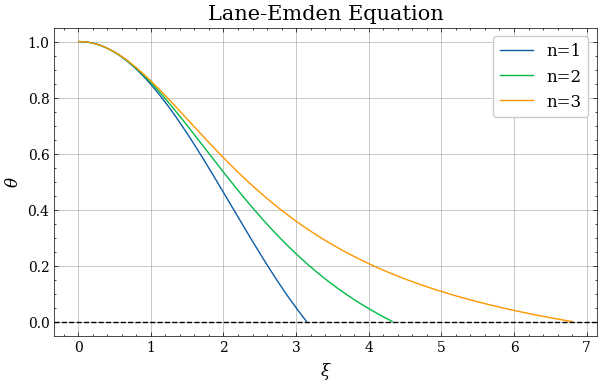

In [93]:
fig = plt.figure(figsize=(7,4))
ax1 = fig.add_subplot(111)
for n in [1,2,3]:
    xs, ys = solveLaneEmden(log_delta_xi=-2, n=n)
    ax1.plot(xs, np.array(ys), label = f'n={n}')

ax1.set_xlabel(r'$\xi$', fontsize=fs-3)
ax1.set_ylabel(r'$\theta$', fontsize=fs-3)
ax1.grid()
ax1.legend(loc='upper right', prop={'size': fs-3}, frameon=True,framealpha=1)
ax1.set_title('Lane-Emden Equation', fontsize=fs)
ax1.axhline(y=0, c='k', ls='--'); plt.show()

```{admonition} Lane–Emden as a First-Order System
:class: note

To make the numerical integration easier, the function `solveLaneEmden` introduces auxiliary variables:

$$
z(\xi) \;=\; \xi^2 \frac{d\theta}{d\xi}, \quad \quad \quad y = \theta.
$$

This converts the second-order Lane-Emden equation into a system of **two coupled first-order ODEs**:

$$
\frac{dy}{d\xi} = \frac{z}{\xi^2}, 
\qquad 
\frac{dz}{d\xi} = -\xi^2 y^n .
$$

This formulation avoids the singular form of the second derivative at $\xi = 0$ and performs reasonably with stepwise numerical methods such as the predictor–corrector scheme as performed by the `solveLaneEmden` function.

```

```{admonition} Debugging your Physics Equation
:class: danger

What happens when a non-integer $n$ (e.g., $n=1.5$) is used to solve the above equation using `solveLaneEmden`? Take note of any warning outputs from the Python interpreter, and log any intermediate outputs from the numerical solver. Why does the warning occur, and how does this affect the output solution?

```



## Training the PINN

We will use the Lane-Emden equation as an illustrative example for training a PINN using **only a physics loss**.

### Setting up a Generator
we first need to set up a generator that will feed in grids of $\xi$ to the PINN. Compared to the plots above, we will generate up to a fixed $\xi$, instead of up to the first zero in $\theta$.

In [114]:
class LaneEmdenGenerator(data.Dataset):
    def __init__(self, solver, log_delta_xi=-2, n = 3, batch_size = 8,
                 generations_per_epoch = 128, terminate = None,
                 device = 'cuda'):

        self.log_delta_xi = log_delta_xi # Logarithmic spacing of xi in the grid
        self.solver = solver
        self.n = n
        self.terminate = terminate
        self.batch_size = batch_size  # How many grids per batch
        self.device = device
        self.generations_per_epoch = 128   # How many batches per epoch

    def __getitem__(self, index):
        xisvec, ycsvec, ennevec = [], [], []

        for i in range(self.batch_size):
            xis, ycs = self.solver(self.log_delta_xi, self.n, self.terminate)
            xis, ycs = np.array(xis), np.array(np.real(ycs))
            
            xisvec.append(np.array(xis))
            ycsvec.append( np.array(np.real(ycs)))
            ennevec.append(np.ones_like(xis)*self.n)

        tuple_set = np.vstack(( np.concatenate(ennevec), np.concatenate(ycsvec), np.concatenate(xisvec) )).T
        tuple_set = tuple_set[~np.isnan(tuple_set[:,1])]
            
        return torch.tensor(tuple_set, dtype=DTYPE).to(self.device)

    def __len__(self):
        return self.generations_per_epoch

The generator `LaneEmdenGenerator` returns a $N \times 3$ vector comprising the following:

- An $N \times 1$ array of polytropic indices $n$, fixed for the problem.
- An $N \times 1$ array of $\theta$ values. These will **not** be explicitly used to solve the PINN in this example.
- An $N \times 1$ array of $\xi$ values, as co-location (grid) points.

### Defining the Networks

In [118]:
class MLP(nn.Module):

    #### A simple multi-layer perceptron ###
    
    def __init__(self, layers, activation=nn.SiLU()):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()

        for i in range(len(layers) - 1):
            linear_layer = nn.Linear(layers[i], layers[i + 1])
            init.xavier_uniform_(linear_layer.weight) # Glorot Uniform initialization
            init.constant_(linear_layer.bias, 0.0)
            self.layers.append(linear_layer)
        self.activation = activation

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            x = self.activation(x)
        return self.layers[-1](x)


class NN_Model(nn.Module):
    def __init__(self, branch_layers, trunk_layers, device='cuda'):
        super(NN_Model, self).__init__()
        
        self.branch_net = MLP(branch_layers, activation=nn.SiLU()).to(device)
        self.trunk_net = MLP(trunk_layers, activation=nn.SiLU()).to(device)
        self.device = device

        self.optimizer = optim.AdamW(self.parameters(), lr=5e-4)
        self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=1-1.25e-5)

        self.loss_log = []
        self.loss_operator_log = []
        self.loss_physics_log = []

    def forward(self, u, y, single=False):

        ## Use single = True in the scenario you need evaluation at a single colocation point (e.g., at boundaries)
        
        if single:
            u = u.unsqueeze(0)
            y = y.unsqueeze(0)
        B = self.branch_net(u)
        T = self.trunk_net(y)
        if single:
            outputs = torch.dot(B.squeeze(), T.squeeze())
        else:
            outputs = torch.sum(B * T, dim=1, keepdim=True)
        return outputs

```{figure} images/deeponet.png
---
height: 370px
width: 500px
name: deeponet
---
Schematic of a Deep Operator Network (DeepONet).

```

In this example, the type of network we will use is inspired by Deep Operator Networks [(DeepONets)](https://arxiv.org/abs/1910.0319). A DeepONet learns a mapping from a function input $u$ to a predicted function value at location $y$. It comprises two components:

- **Branch Net $B(u)$:** Encodes information about the input function $u$. In our Lane-Emden equation, $u=n$.

- **Trunk Net $T(y)$:** Encodes information about the coordinate or location $y$. In our Lane-Emden equation, $y=\xi$

Both Branch and Trunk nets are Multilayer Perceptrons.

The final prediction is given by the inner product

$$
\hat{f}(u,y) \;=\; \sum_{j=1}^{p} B_j(u)\,T_j(y),
$$

i.e., a weighted combination of branch and trunk features.

```{admonition} Why a DeepONet?
:class: tip

Unlike a standard MLP, which directly maps $(u,y) \mapsto f(u,y)$, a DeepONet factorizes the prediction:

$$
\hat{f}(u,y) \;=\; \sum_{j=1}^{p} B_j(u)\,T_j(y),
$$

where:
- $B(u)$ encodes the input function (branch net),
- $T(y)$ encodes the evaluation coordinate (trunk net).

Once trained, the model can evaluate $f(u,y)$ at **new values of $y$**, even if they were not explicitly included in the training set.  
In other words, DeepONets generalize across the domain of $y$, turning the network into an **operator approximator** rather than a pointwise regressor.
```

### Losses -- Physics Constraint

Next, we will define functions corresponding to equations {eq}`eq-lane-emden`.

In [137]:
def compute_sample_ode_loss(model, n, ξ):
    ### Computes the residual of the equation ###
    
    pred = model.forward(n, ξ, True)
    ddξ_ξ2_dθdξ = grad(lambda ξ: (ξ ** 2 * grad(model.forward, argnums=1)(n, ξ, True)).squeeze(), argnums=0)(ξ)  # LHS
    ξ2_θn = - ( (ξ ** 2) * (pred ** n )  )  ## RHS
    residual = ddξ_ξ2_dθdξ - ξ2_θn
    
    return residual

def compute_ode_loss(model, n, ξ):
    n = n.clone().detach().requires_grad_(True)
    ξ = ξ.clone().detach().requires_grad_(True)
    residuals = vmap(compute_sample_ode_loss, in_dims=(None, 0, 0))(model, n, ξ)
    return F.mse_loss(residuals, torch.zeros_like(residuals))

```{admonition} Batched Gradients
:class: tip

In PINNs, we often need to evaluate PDE residuals at many collocation points.  

- **`grad`** computes derivatives of the network output with respect to its inputs.  
  Nested calls allow higher-order derivatives (e.g. the second derivative in the Lane–Emden equation).

- **`vmap`** vectorizes these gradient calculations across a batch of collocation points, replacing an explicit Python for-loop with an efficient parallel computation.
    - `in_dims=(None, 0, 0)` applies to each input argument, i.e., `(model, n, ξ)`. This means `model` is not vectorized, while `n` and `ξ` are vectorized over the first axis.

This is in opposition to `torch.autograd.grad` alone, which does not return per-sample gradients in a batch. Therefore, the following code allows the ODE residual for an entire batch of inputs in one pass:
```python
residuals = vmap(self.compute_sample_ode_loss)(model, n, ξ)
```

### Losses -- Boundary Conditions

We now define the losses for the boundary conditions as defined in {eq}`boundary-lane-emden`.

For the condition of $\frac{d\theta}{d\xi}=0$ for $\xi=0$, see that:
- `compute_sample_innergrad_loss` returns the **gradient** $\frac{d\theta}{d\xi}$.
- The MSE loss is calculated with respect to the zero vector (`torch.zeros_like(inner_grad)`)

In [138]:
### dθdξ(ξ=0) = 0 ###
def compute_sample_innergrad_loss(model, n, ξ):
    return grad(model.forward, argnums=1)(n, ξ, True)

def compute_inner_grad_loss(model, n, ξ):
    n = n.clone().detach().requires_grad_(True)
    ξ = ξ.clone().detach().requires_grad_(True)*0.  ### ξ=0 
    inner_grad = vmap(compute_sample_innergrad_loss, in_dims=(None, 0, 0))(model, n, ξ)
    return  F.mse_loss(inner_grad, torch.zeros_like(inner_grad)) ### dθ/dξ=0 

For the condition of $\theta=0$ for $\xi=1$, see that:
- `compute_sample_innerbc_loss` returns the **function value** $\theta$.
- The MSE loss is calculated with respect to a vector of ones (`torch.ones_like(inner_bc_pred)`)

In [139]:
### θ(ξ=0) = 1 ###
def compute_sample_innerbc_loss(model, n, ξ):
    pred_at_boundary = model.forward(n, ξ, True)
    return pred_at_boundary

def compute_inner_bc_loss(model, n, ξ):
    n = n.clone().detach().requires_grad_(True)
    ξ = ξ.clone().detach().requires_grad_(True)*0.  ### ξ=0 
    inner_bc_pred = vmap(compute_sample_innerbc_loss, in_dims=(None, 0, 0))(model, n, ξ)
    return  F.mse_loss(inner_bc_pred, torch.ones_like(inner_bc_pred))  ### θ=1 

### Training Loop

Putting it altogether, we have the following for the training step:

In [140]:
def training_step(model, n, ξ):
    model.optimizer.zero_grad()
    boundary_loss, deriv_loss = 0, 0

    ode_loss = compute_ode_loss(model, n, ξ)  # Physics 
    deriv_loss = compute_inner_grad_loss(model, n, ξ)  # Boundary Condition for Derivative
    boundary_loss = compute_inner_bc_loss(model, n, ξ) # Boundary Condition for Value

    total_loss = ode_loss + 1e4*boundary_loss + 1e4*deriv_loss  # weighting BC by an arbitrary factor
    total_loss.backward()

    model.optimizer.step()
    model.scheduler.step()
    return ode_loss.item(), boundary_loss.item(), deriv_loss.item()

and the following function `train` for the training loop. A function `visualize_example` is first defined to allow us to keep track of the PINN predictions with those from numerical integration during the training.

In [150]:
def visualize_example(model, operator_dataloader, iteration):

    ### Comparing the Numerical Integration with Predictions from the PINN ###
    
    xisvec, ycsvec, ennevec = [], [], []
    xis, ycs = operator_dataloader.solver(operator_dataloader.log_delta_xi, operator_dataloader.n)
    xis, ycs = np.array(xis), np.array(np.real(ycs))

    xisvec.append(np.array(xis))
    ycsvec.append(np.array(np.real(ycs)))
    ennevec.append(np.ones_like(xis)*n)

    tuple_set = np.vstack(( np.concatenate(ennevec), np.concatenate(ycsvec), np.concatenate(xisvec) )).T
    tuple_set = tuple_set[~np.isnan(tuple_set[:,1])]
    tuple_set_tensor = torch.tensor(tuple_set, dtype=DTYPE).to(model.device)

    with torch.no_grad():
        pred = model.forward(tuple_set_tensor[:,0].unsqueeze(-1), tuple_set_tensor[:,2].unsqueeze(-1) )

    fig = plt.figure(figsize=(5,5))
    plt.plot(tuple_set[:,2], tuple_set[:,1], label='Manual')
    plt.plot(tuple_set_tensor[:,2].data.cpu().numpy(), pred[:].data.cpu().numpy(), c='r', label='PINN')
    plt.title(f'n: {n}, Iteration: {iteration}', fontsize=fs-5)
    plt.text(x=0.65, y= 0.75, fontsize=fs-5,
             s= 'Lane-Emden Eqn.\n'+r"$\frac{1}{\xi^2} \frac{d}{d\xi} \left( \xi^2 \frac{d\theta}{d\xi} \right) + \theta^n = 0$" , transform=plt.gca().transAxes)
    plt.legend(loc='upper right'); plt.xlabel('ξ', fontsize=fs); plt.ylabel('θ', fontsize=fs-3)
    plt.ylim(-0.1, 1.1); plt.tick_params(axis='both', which='major', labelsize=fs-3); plt.axhline(y=0, c='k', ls='--')
    plt.show()


def train(model, operator_dataloader, nIter = 100):
    
    for i in range(nIter): #nIter is number of training epochs
        boundary_loss_vec = [] 
        derivative_loss_vec = []
        ode_loss_vec = []

        print(f'Iteration {i}')
        pbar = trange(len(operator_dataloader))
        for _, batch in zip(pbar, operator_dataloader):

            n_batch, _, ξ_batch = batch[:,0].unsqueeze(-1), _, batch[:,2].unsqueeze(-1)
            
            ode_loss_value, boundary_loss_value, derivative_loss_value = training_step(model, n_batch, ξ_batch)

            pbar.set_postfix({'Boundary Loss': boundary_loss_value,
                              'Derivative Loss': derivative_loss_value,
                              'ODE Loss': ode_loss_value,
                             'learning rate': model.optimizer.param_groups[0]['lr']})

            boundary_loss_vec.append(boundary_loss_value)
            derivative_loss_vec.append(derivative_loss_value)
            ode_loss_vec.append(ode_loss_value)

        print(f'Average ODE Loss: {np.mean(ode_loss_vec)}\nAverage Boundary Loss: {np.mean(boundary_loss_vec)}\n\
        Average Derivative Loss: {np.mean(derivative_loss_vec)},\n\
              Average Total Loss: {np.mean(ode_loss_vec) +np.mean(boundary_loss_vec) + np.mean(derivative_loss_vec)}')
        pbar.close()

        visualize_example(model, operator_dataloader, i)

Next, we initialize the generator and model:

In [153]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gen = LaneEmdenGenerator(solver=solveLaneEmden, log_delta_xi=-2, n=3, device=device)

## MLP Architecture ##
num_neurons = 32
num_layers = 8
n_dim = ξ_dim = 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

branch_layers = [n_dim] + [num_neurons] * num_layers
trunk_layers = [ξ_dim] + [num_neurons] * num_layers
model = NN_Model(branch_layers, trunk_layers, device = device)

And finally, we run the `train` function with the previously defined generator of Lane-Emden equations, `gen = LaneEmdenGenerator`.

Iteration 0


  0%|          | 0/128 [00:00<?, ?it/s]

Average ODE Loss: 24.122644430177534
Average Boundary Loss: 0.2638139855922991
        Average Derivative Loss: 0.0010952500281471785,
              Average Total Loss: 24.38755366579798


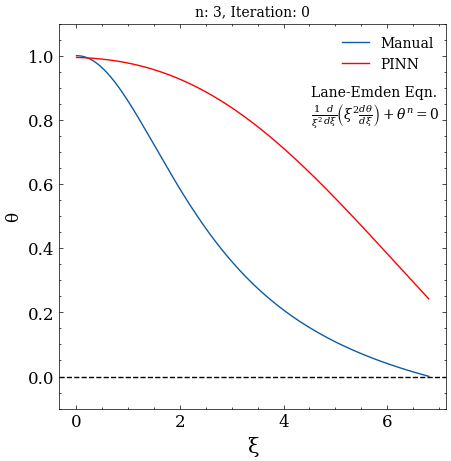

Iteration 1


  0%|          | 0/128 [00:00<?, ?it/s]

Average ODE Loss: 3.7149846265878783
Average Boundary Loss: 2.8962180221825727e-06
        Average Derivative Loss: 1.2901252987648375e-05,
              Average Total Loss: 3.7150004240588883


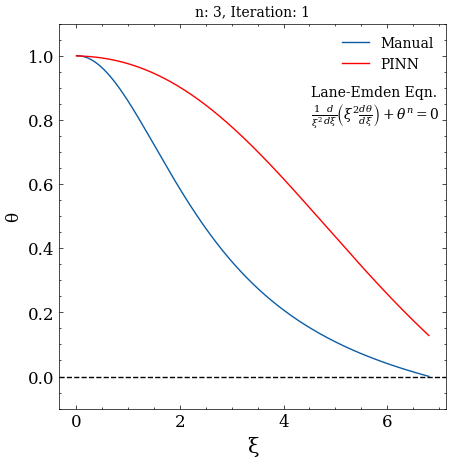

Iteration 2


  0%|          | 0/128 [00:00<?, ?it/s]

Average ODE Loss: 1.52657016930806
Average Boundary Loss: 3.904653945646213e-07
        Average Derivative Loss: 2.658476285244073e-06,
              Average Total Loss: 1.5265732182497398


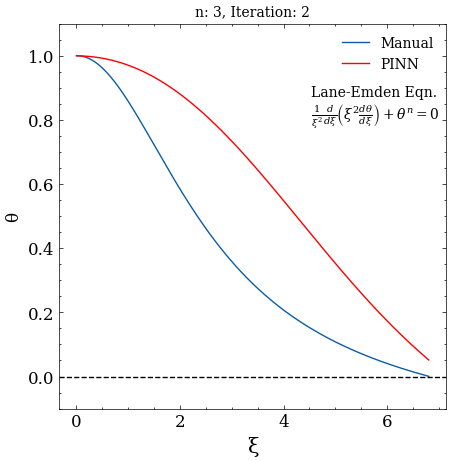

In [154]:
train(model, gen, nIter = 1000)

The PINN may take some time to fully converge, but the following demonstrates the convergence of the PINN to the numerical solution.

![](https://raw.githubusercontent.com/mtyhon/astropinn/main/images/laneemden_n3_downsample10.gif)

## Other ODEs in Astrophysics

Many physical systems in astrophysics (and physics in general) are described by systems of ODEs. The following are several examples

### Example 1 - Planetary Motion

The [Kepler problem](https://en.wikipedia.org/wiki/Kepler_problem) describes the motion of a secondary body (planet, asteroid, comet, etc.) around a primary body.  In the orbital ($x-y$) plane, the total energy of the of the system is described by its Hamiltonian $H_{\mathrm{Kepler}}$:

$$
H_{\mathrm{Kepler}} = \frac{1}{2\mu}(p_x^2+p_y^2)-\frac{\mu}{\sqrt{x^2+y^2}},
$$

where:
- $\mu = G(m_1+m_2)$ is the gravitational parameter,
- $p_x, p_y$ are the canonical momenta,
- $(x,y)$ are the relative coordinates of the secondary body.

Using Hamilton’s equations, the equations of motion are:

$$
\begin{aligned}
\dot{x} &= u, \\
\dot{y} &= v, \\
\dot{u} &= -\frac{\mu x}{(x^2+y^2)^{3/2}}, \\
\dot{v} &= -\frac{\mu y}{(x^2+y^2)^{3/2}},
\end{aligned}
$$

Here, $u$ and $v$ are, respectively, the $x$ and $y$ components of the velocity, such that $p_x = \mu u$ and $p_y = \mu v$.


```{admonition} Exercise: Kepler problem PINN
:class: note

Write a Python function that computes the **physics loss** for a PINN solving the Kepler problem.  
Your function should:
1. Take as input the predicted states $(x,y,u,v)$ at collocation points in time.
2. Use **batched** automatic differentiation to compute time derivatives $(\dot{x}, \dot{y}, \dot{u}, \dot{v})$.
3. Compute the residuals of the four Kepler ODEs above.
4. Return the mean squared residual as the physics loss.

```python
def kepler_physics_loss(model, t, μ):
    """
    model: neural network predicting [x, y, u, v] as a function of time t. Output is of dimensionality $N\times 4$
    t: tensor of collocation times of dimensionality $N\times 1$
    μ: gravitational parameter
    """
    # 1. Predict states from the model
    x, y, u, v = model(t).T
    
    # 2. Compute time derivatives using torch.func.grad
    dx_dt = ...
    dy_dt = ...
    du_dt = ...
    dv_dt = ...
    
    # 3. Define residuals according to the equations of motion
    res_x = ...
    res_y = ...
    res_u = ...
    res_v = ...
    
    # 4. Return physics loss
    loss_phys = ...
    return loss_phys

```

### Example 2 - Friedmann Acceleration Equation

For a flat FLRW universe $(k=0)$ containing matter and a cosmological constant $\Lambda$, the evolution of the universe with time $t$ can be written as $\tau = H_0 t$ where $H_0$ is the Hubble constant. The universe's expansion can be described by the (dimensionless) **Friedmann acceleration equation**:  

$$
\frac{a''(\tau)}{a(\tau)} 
= \overbrace{-\frac{1}{2}\frac{\Omega_m}{a(\tau)^3}}^{\text{Gravitational deceleration from matter}} \overbrace{+ \Omega_\Lambda}^{\text{Accelerated expansion due to dark energy}},
$$

which forms the following second-order ODE:

$$
a''(\tau)
= -\frac{1}{2}\frac{\Omega_m}{a(\tau)^2} + \Omega_\Lambda a(\tau),
$$

where primes denote derivatives with respect to $\tau$. The scale factor $a(\tau)$ describes **how distances in the universe expand with time** as **first slowing down** (matter-dominated) before being **accelerated** later on (dark energy-dominated). Here, $\Omega_m$ is the present-day matter density parameter, while $\Omega_\Lambda$ is the present-day dark energy density parameter. The boundary conditions for the ODE are the following:

   - $a(0) = 0$ (Big Bang),
   - $a(\tau_0) = 1$ (present day),
   - optionally $\,a'(\tau_0)=1$ (since time is scaled by $H_0^{-1}$).

```{admonition} Exercise: The Friedmann Acceleration Equation
:class: exercise

Implement a physics-informed loss for a PINN that learns the scale factor $a(\tau)$.
Your function should:
1. Predict $a(\tau)$ at collocation points using the neural network.  
2. Use **batched** automatic differentiation to compute the second derivative $a''(\tau)$.  
2. Impose boundary conditions from **batched** first derivatives $a'(\tau)$ and **batched** predictions $a(\tau)$.
3. Form the residuals and return the mean squared residual as the physics loss.

```python
def friedmann_loss(model, τ, Ωm, ΩΛ, τ0=1.0):

    # 1. $a(\tau)$
    a = model(τ).squeeze()

    # 2. First and second derivatives
    da_dτ = ...
    d2a_dτ2 = ...

    # 3. Define residuals from physics loss
    phys_residual = ...

    # 4. Define residuals from boundary conditions loss
    a0 = ...
    a_today = ...
    adot_today = ...
    
    bc_residual = ...
    
    # 4. Return loss as combination of residuals
    loss = ...

    return loss



```{admonition} The Dimensionless Form of the Friedmann Acceleration Equation
:class: dropdown

The Friedmann acceleration equation in cosmic time is:

$$
\frac{\ddot{a}(t)}{a(t)} 
= -\frac{4\pi G}{3}\rho_m(t) + \frac{\Lambda}{3}.
$$

Here $a(t)$ is the scale factor, and the present epoch is defined as $t=t_0$, such that $a(t)$ is normalized so that $a(t_0)=1$ today. We note that the Hubble constant is

$$
H_0 \;\equiv\; \frac{\dot{a}(t_0)}{a(t_0)},
$$

and we define the dimensionless time as $\tau \;=\; H_0\,t$, such that:

$$
\begin{aligned}
\frac{d^2}{dt^2} &= H_0^2 \frac{d^2}{d\tau^2}.
\end{aligned}
$$

Next, we define the critical density:

$$
\rho_c \;=\; \frac{3H_0^2}{8\pi G},
$$

and density parameters

$$
\begin{aligned}
\Omega_m &= \frac{\rho_{m,0}}{\rho_c},\\ 
\Omega_\Lambda &= \frac{\Lambda}{3H_0^2}.
\end{aligned}
$$

From energy conservation (the cosmological fluid equation):

$$
\dot{\rho} + 3\frac{\dot{a}}{a}(\rho + p/c^2) = 0,
$$

where for pressureless matter $(p=0)$:

$$
\rho_m(t) = \rho_{m,0}\,a(t)^{-3}.
$$

Substituting the above into the acceleration equation gives:

$$
\frac{a''(\tau)}{a(\tau)} 
= -\frac{1}{2}\frac{\Omega_m}{a(\tau)^3} + \Omega_\Lambda,
$$

where primes denote derivatives with respect to $\tau$.

Because time is scaled by $H_0^{-1}$:

- $a(0)=0$ (Big Bang)  
- $a(\tau_0)=1$ (Present day, normalized)  
- $a'(\tau_0)=1$ (Since $\dot{a}(t_0)=H_0$).  

See also: [Lecture Notes on Cosmology](https://people.ast.cam.ac.uk/~pettini/Intro%20Cosmology/Lecture04.pdf)